# GAN creation

## Config

In [5]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install -q kaggle Pillow imageio matplotlib pandas
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip -q 140k-real-and-fake-faces.zip


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
... resuming from 3305111552 bytes (719444166 bytes left) ...
100%|█████████████████████████████████████▉| 3.74G/3.75G [00:20<00:00, 60.5MB/s]
100%|██████████████████████████████████████| 3.75G/3.75G [00:20<00:00, 34.9MB/s]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
import pickle

In [7]:
# Setting GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
BATCH_SIZE = 256
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
LATENT_FEATURES = 100
NUM_IMAGES = 25000
GENERATOR_PATH = "generator.keras"
DISCRIMINATOR_PATH = "discriminator.keras"

## GAN training data

In [9]:
# For sampling real and fake images
def sample_each_label(df,no_imgs=25000,shuffle=False):
    each_label_images = int(no_imgs / 2)
    subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=each_label_images, random_state=69)
    final_subset = pd.concat([subset_label_0, subset_label_1])
    if shuffle == True:
        final_subset = final_subset.sample(frac=1, random_state=69).reset_index(drop=True)
    return final_subset

def read_image(image_file, label):
    image = tf.io.read_file("real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

def augument(image, label):
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH], method=tf.image.ResizeMethod.GAUSSIAN)
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5 # Adjusting pixel range between -1 and 1
    return image, label

df = pd.read_csv("real_vs_fake/train.csv")
df = sample_each_label(df,no_imgs=NUM_IMAGES,shuffle=True)

dataset = tf.data.Dataset.from_tensor_slices((df['path'].values,df['label'].values))
dataset = dataset.map(read_image).map(augument).batch(BATCH_SIZE)

In [10]:
# For sampling only real images
# df = pd.read_csv("real_vs_fake/train.csv")
# df_real = df[df['label'] == 1]
# df_real = df_real.sample(NUM_IMAGES, random_state=69)
# df_real = df_real.sample(frac=1, random_state=69).reset_index(drop=True)
# image_paths = df_real['path'].tolist()

# image_paths = ["real_vs_fake/real-vs-fake/" + path for path in image_paths]

# dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# def preprocess_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=tf.image.ResizeMethod.GAUSSIAN)
#     img = tf.cast(img, tf.float32)
#     img = (img - 127.5) / 127.5 # Adjusting pixel range between -1 and 1
#     return img

# dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset = dataset.batch(BATCH_SIZE)

tf.Tensor(
[1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0
 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0
 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0
 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1
 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1], shape=(256,), dtype=int64)


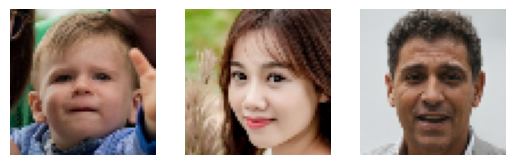

2024-08-26 17:41:56.622528: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
def display_imgs(dataset, num_images=1):
    for batch, labels in dataset.take(1):
      print(labels)
      batch = (batch + 1) / 2
      for i in range(min(BATCH_SIZE, num_images)):
          plt.subplot(1, num_images, i + 1)
          plt.imshow(batch[i].numpy())
          plt.axis("off")
      plt.show()

display_imgs(dataset,num_images=3)

In [12]:
len(dataset)

98

## GAN architecture

In [13]:
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, ReLU, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, ZeroPadding2D, UpSampling2D, Activation, MaxPooling2D

### Generator

In [14]:
def build_generator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Dense(2*2*512, input_dim=LATENT_FEATURES, kernel_initializer=init))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((2,2,512)))

    model.add(Conv2DTranspose(256, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', activation='tanh', kernel_initializer=init, use_bias=False))

    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │       206,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         1,536 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,993,664 (11.42 MB)

 Trainable params: 2,993,664 (11.42 MB)

 Non-trainable params: 0 (0.00 B)

2024-08-26 17:42:06.234433: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1724694126.270661     373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724694126.287186     373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724694126.287870     373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724694126.288254     373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724694126.308020     373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724694126.308449     373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724694126.308841     373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724694126.310229     373 gpu_t

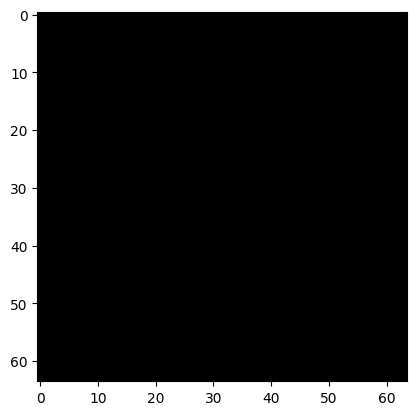

In [15]:
img = generator(np.random.normal(size=(1, LATENT_FEATURES, 1)))
plt.imshow(img[0])

### Discriminator

In [16]:
def build_discriminator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Conv2D(32, 4, 2, padding='same',
                     input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,3),
                     kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 4, 2, padding='same', kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 4, 2, padding='same', kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, 4, 2, padding='same', kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, 4, 2, padding='same', kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(1024, 2, 1, kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 1024)     │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,884,993 (18.63 MB)

 Trainable params: 4,884,993 (18.63 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
img = generator.predict(np.random.normal(size=(4, LATENT_FEATURES, 1)))
discriminator.predict(img)

I0000 00:00:1724694127.329303     521 service.cc:146] XLA service 0x7cd23c0044a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724694127.329330     521 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-26 17:42:07.334375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


I0000 00:00:1724694127.613573     521 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


array([[0.49999964],
       [0.50000316],
       [0.5000019 ],
       [0.50000113]], dtype=float32)

## Training loop

In [18]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback

In [19]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Train the discriminator
        batch, labels = batch
        with tf.GradientTape() as d_tape:
            real_images = batch
            ypred_real = self.discriminator(real_images, training=True)
            # y_real = tf.ones_like(ypred_real)
            # noise_real = -0.10*tf.random.uniform(tf.shape(ypred_real))
            # y_real += noise_real
            real_d_loss = self.d_loss(labels, ypred_real)
        # dgrad = d_tape.gradient(real_d_loss, self.discriminator.trainable_variables)
        # self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # with tf.GradientTape() as d_tape:
            fake_images = self.generator(tf.random.normal((BATCH_SIZE, LATENT_FEATURES, 1)), training=False)
            ypred_fake = self.discriminator(fake_images, training=True)
            y_fake = tf.zeros_like(ypred_fake)
            # noise_fake = 0.10*tf.random.uniform(tf.shape(ypred_fake))
            # y_fake += noise_fake
            fake_d_loss = self.d_loss(y_fake, ypred_fake)

            total_d_loss = real_d_loss + fake_d_loss
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((BATCH_SIZE,LATENT_FEATURES,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss,"d_loss_real":real_d_loss,"d_loss_fake":fake_d_loss, "g_loss":total_g_loss}

In [20]:
d_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [21]:
class ModelMonitor(Callback):
    def __init__(self, latent_dim=LATENT_FEATURES):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            random_latent_vectors = tf.random.uniform((1, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = (generated_images + 1) / 2
            generated_images = generated_images.numpy()
            img = array_to_img(generated_images[0])
            os.makedirs("training/", exist_ok=True)
            img.save(f'training/{epoch}_generated_img.png')
            generator.save(GENERATOR_PATH,include_optimizer=True)
            discriminator.save(DISCRIMINATOR_PATH,include_optimizer=True)


## Training

In [ ]:
hist = gan.fit(dataset, epochs=500, callbacks=[ModelMonitor()])

plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['d_loss_real'], label='d_loss_real')
plt.plot(hist.history['d_loss_fake'], label='d_loss_fake')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

Epoch 1/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - d_loss: 1.3482 - d_loss_fake: 0.6959 - d_loss_real: 0.6522 - g_loss: 0.6977
Epoch 2/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - d_loss: 1.2766 - d_loss_fake: 0.6914 - d_loss_real: 0.5852 - g_loss: 0.7085
Epoch 3/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - d_loss: 1.2267 - d_loss_fake: 0.6812 - d_loss_real: 0.5455 - g_loss: 0.7188
Epoch 4/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - d_loss: 1.1914 - d_loss_fake: 0.6779 - d_loss_real: 0.5136 - g_loss: 0.7277
Epoch 5/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - d_loss: 1.1499 - d_loss_fake: 0.6694 - d_loss_real: 0.4805 - g_loss: 0.7393
Epoch 6/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - d_loss: 1.1052 - d_loss_fake: 0.6559 - d_loss_real: 0.4494 - g_loss: 0.7518
Epoch 7/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - d_loss: 1.0705 - d_loss_fake: 0.6485 - d_loss_real: 0.4221 - g_loss: 0.7571
Epoch 8/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - d_loss: 1.0302 - d_loss_fake: 0.636

In [ ]:
# Function to convert images to GIF
def convert_images_to_gif(input_folder, output_gif_path):
    images = []
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            images.append(img)

    # Save images as GIF
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=200, loop=1)

# Example usage
input_folder = "training/"
output_gif_path = "training.gif"

convert_images_to_gif(input_folder, output_gif_path)

In [ ]:
img = generator.predict(tf.random.normal((1, LATENT_FEATURES, 1)))
img = (img + 1) / 2
plt.imshow(img[0])

In [ ]:
with open("GAN_history", 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

## Discriminator testing

In [ ]:
from keras.models import load_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
discriminator = load_model(DISCRIMINATOR_PATH)
discriminator.compile(optimizer=Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=BinaryCrossentropy(), metrics=['accuracy'])

### (real + styleGAN) images

In [ ]:
def sample_each_label(df,no_imgs=25000,shuffle=False):
    each_label_images = int(no_imgs / 2)
    subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=each_label_images, random_state=69)
    final_subset = pd.concat([subset_label_0, subset_label_1])
    if shuffle == True:
        final_subset = final_subset.sample(frac=1, random_state=69).reset_index(drop=True)
    return final_subset

def read_image(image_file, label):
    image = tf.io.read_file("real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

def augument(image, label):
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH], method=tf.image.ResizeMethod.GAUSSIAN)
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5 # Adjusting pixel range between -1 and 1
    return image, label

In [ ]:
test  = pd.read_csv("real_vs_fake/test.csv")
test = sample_each_label(test,no_imgs=10000,shuffle=False)
test_dataset = tf.data.Dataset.from_tensor_slices((test['path'].values,test['label'].values))
test_dataset = test_dataset.map(read_image).map(augument).batch(1)

In [ ]:
discriminator.evaluate(test_dataset, verbose=0, return_dict=True)
# for batch in test_dataset.take(1):
#     print(discriminator.predict(batch, verbose=0))

{'accuracy': 0.490200012922287, 'loss': 7.719520092010498}

### (real + generator) images

In [ ]:
def save_fake(output_dir,num_images=1000, verbose=False):
    generator = tf.keras.models.load_model(GENERATOR_PATH)
    generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
                        loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    os.makedirs(output_dir, exist_ok=True)

    generated_images = generator.predict(tf.random.normal((num_images, LATENT_FEATURES, 1)),verbose=0)

    for i in range(num_images):
        image = generated_images[i]
        image = (image + 1) / 2
        image_path = os.path.join(output_dir, f"{i}.jpg")
        tf.keras.preprocessing.image.save_img(image_path, image)
    if verbose:
        print(f"{i + 1} images generated and saved to {output_dir}.")

def save_real(df, destination_dir, num_images=1000):
    subset_label_1 = df[df['label'] == 1].sample(n=num_images, random_state=69)
    os.makedirs(destination_dir, exist_ok=True)
    for i, file_path in enumerate(subset_label_1['path'].tolist()):
        with Image.open(file_path) as img:
            output_path = os.path.join(destination_dir, f"{i}.jpg")
            img.save(output_path)
    print(f"{num_images} images saved to {destination_dir}.")

def augument(x, y):
    img = tf.cast(x, tf.float32)
    img = (img - 127.5) / 127.5
    return img, y

In [ ]:
save_fake("resnet_data/test/0",num_images=5000)
test  = pd.read_csv("real_vs_fake/test.csv")
save_real(test, "resnet_data/test/1", num_images=5000)

In [ ]:
test_dataset_generator = tf.keras.preprocessing.image_dataset_from_directory(
    "resnet_data/test",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    interpolation='gaussian',
    shuffle=True,
    seed=69,
)
test_dataset_generator = test_dataset_generator.map(augument)

In [ ]:
for batch, labels in test_dataset_generator.take(1):
    batch = (batch + 1) / 2
    num_images = 3
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.imshow(batch[i])
        plt.title(f"Label:{labels[i]}")
        plt.axis("off")
    plt.show()

In [ ]:
discriminator.evaluate(test_dataset_generator, verbose=0,return_dict=True)

{'loss': 0.23886162042617798, 'accuracy': 0.9139500260353088}

## Further training with styleGAN images + real images

In [ ]:
from keras.models import load_model
os.makedirs("models/", exist_ok=True)
discriminator = load_model("models/discriminator.keras")
discriminator.compile(optimizer=Adam(learning_rate=0.002,beta_1=0.5),
                      loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
# SWITCH THIS WITH IMAGEDATAGENERATOR
train = pd.read_csv("real_vs_fake/train.csv")
valid = pd.read_csv("real_vs_fake/valid.csv")
test  = pd.read_csv("real_vs_fake/test.csv")

def random_n_images(df,no_imgs=25000,shuffle=False):
    each_label_images = int(no_imgs / 2)
    subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=each_label_images, random_state=69)
    final_subset = pd.concat([subset_label_0, subset_label_1])
    if shuffle == True:
        final_subset = final_subset.sample(frac=1, random_state=69).reset_index(drop=True)
    return final_subset

def read_image(image_file, label):
    image = tf.io.read_file("real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

def augument(image, label):
    image = tf.image.resize(image, [image_height, image_width], method=tf.image.ResizeMethod.GAUSSIAN)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image, label

def create_data(csv_path, no_imgs=25000, shuffle=False):
    df = pd.read_csv(csv_path)
    df_subset = random_n_images(df,no_imgs=no_imgs,shuffle=shuffle)
    data = tf.data.Dataset.from_tensor_slices((df_subset['path'].values,df_subset['label'].values))
    return

train_data = create_data("real_vs_fake/train.csv", no_imgs=50000, shuffle=True)
valid_data = create_data("real_vs_fake/valid.csv", no_imgs=10000, shuffle=False)
test_data = create_data("real_vs_fake/test.csv", no_imgs=20000, shuffle=False)


train_data = train_data.map(read_image).map(augument).batch(BATCH_SIZE).prefetch(1)
validation_data = validation_data.map(read_image).map(augument).batch(BATCH_SIZE).prefetch(1)
test_data = test_data.map(read_image).map(augument).batch(1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    brightness_range=(0.5, 1.5),
    shear_range=.5,
    fill_mode="nearest",
    horizontal_flip=.5,
    preprocessing_function=lambda x: (x - 127.5) / 127.5,
    dtype=np.float32,
    validation_split=.5
)

validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: (x - 127.5) / 127.5,
    dtype=np.float32,
    validation_split=.5
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: (x - 127.5) / 127.5,
    dtype=np.float32,
)

In [ ]:
train_data = train_generator.flow_from_directory(
    "real_vs_fake/real-vs-fake/train",
    target_size=(image_height, image_width),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=69,
    interpolation="nearest",
    # keep_aspect_ratio=False,
    subset="training"
)

validation_data = train_generator.flow_from_directory(
    "real_vs_fake/real-vs-fake/valid",
    target_size=(image_height, image_width),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=69,
    interpolation="nearest",
    # keep_aspect_ratio=False,
    subset="validation"
)

test_data = train_generator.flow_from_directory(
    "real_vs_fake/real-vs-fake/test",
    target_size=(image_height, image_width),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=69,
    interpolation="nearest",
    # keep_aspect_ratio=False,
)

Found 50000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


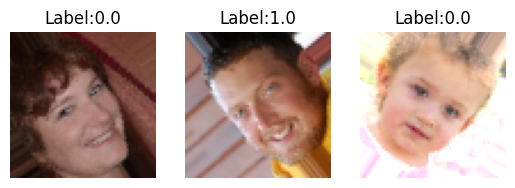

In [ ]:
images, labels = train_data.next()
for i in range(3):
    plt.subplot(1,3,i+1)
    image = images[i]
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f"Label:{labels[i]}")
    plt.axis("off")
plt.show()

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint("models/discriminator_separate_trained.keras",monitor="val_loss")

In [ ]:
discriminator_history = discriminator.fit(train_data,validation_data=validation_data,callbacks=[cp_callback], epochs=10)

Epoch 1/10
196/196 [==============================] - 174s 839ms/step - loss: 0.8065 - accuracy: 0.5703 - val_loss: 0.7289 - val_accuracy: 0.5545
Epoch 2/10
196/196 [==============================] - 147s 752ms/step - loss: 0.6741 - accuracy: 0.6181 - val_loss: 0.6835 - val_accuracy: 0.5965
Epoch 3/10
196/196 [==============================] - 144s 735ms/step - loss: 0.6459 - accuracy: 0.6410 - val_loss: 0.6249 - val_accuracy: 0.6443
Epoch 4/10
196/196 [==============================] - 161s 825ms/step - loss: 0.6276 - accuracy: 0.6606 - val_loss: 0.6089 - val_accuracy: 0.6573
Epoch 5/10
196/196 [==============================] - 142s 727ms/step - loss: 0.6115 - accuracy: 0.6735 - val_loss: 0.7736 - val_accuracy: 0.5711
Epoch 6/10
196/196 [==============================] - 144s 734ms/step - loss: 0.5992 - accuracy: 0.6829 - val_loss: 0.6345 - val_accuracy: 0.6408
Epoch 7/10
196/196 [==============================] - 155s 790ms/step - loss: 0.5890 - accuracy: 0.6895 - val_loss: 0.5935 -

In [ ]:
discriminator.evaluate(test_data, verbose=0,return_dict=True)

{'loss': 0.5756312608718872, 'accuracy': 0.6858999729156494}